7373


,adduct_smiles,binder_atom_name,binder_id_in_adduct,binder_mol,binder_smiles,binder_type,chain_id,chain_name,common_name,covalent_bond_record,doi,note,pdb_id,pdb_title,reaction_type,recovery_strategy,res_atom_name,res_name,res_num,unp_accessionid,unp_resnum,warhead_name,warhead_smarts,multistep,short_adduct_id,adduct_pdb,InChIKey,adduct_InChIKey,res_quad,binder_quad,binder_atom_alt,res_atom_alt,binder_chain_id,binder_num,drugbank_id,drugbank_groups,record_id,binder_id,full_residue_name,BindingDB_react_id
adduct_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1C7Q_A_HIS_306_?_ND1_?_A_BE1_500_?_C1_?,O=C(C[BiH2])NCCOP(=O)(O)O,C1,BE1,,O=C(CBr)NCCOP(=O)(O)O,inhibitor,A,PHOSPHOGLUCOSE ISOMERASE,NaN,"1C7Q,A,A,HIS,HIS,306,306,?,ND1,?,polymer,B,A,BE1,BE1,.,500,?,C1,?,non-polymer",10.1074/jbc.M002017200,NaN,1C7Q,THE CRYSTAL STRUCTURE OF PHOSPHOGLUCOSE ISOMERASE/AUTOCRINE MOTILITY FACTOR/NEUROLEUKIN COMPLEXED WITH ITS CARBOHYDRATE PHOSPHATE INHIBITORS AND ITS SUBSTRATE RECOGNITION MECHANISM,NaN,manual,ND1,HIS,306,P13376,306,Haloacetamide,"[F,Cl,Br,I]CC(=O)(N)",NaN,HIS_ND1_BE1_C1,,MUORYJVNLAHVKL-UHFFFAOYSA-N,HISJWWIPURRDBG-UHFFFAOYSA-O,1C7Q_A_306_HIS,1C7Q_A_500_BE1,?,?,A,500,NaN,NaN,CBR000001,CB0000001,Histidine,NaN

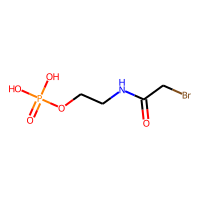
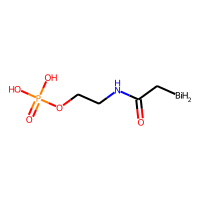

In [2]:
from io import StringIO  
import pandas as pd, math, json, os, sys
from rdkit import Chem
Chem.WrapLogs()  
from rdkit.Chem import PandasTools, SDWriter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#with pd.option_context("display.max_rows", 1000): display(df_recovered)
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) 
PandasTools.RenderImagesInAllDataFrames(images=True) 
df = pd.read_pickle('data/df_processed.pkl') 
df = df[df['InChIKey'].notna()]  
df = df.drop_duplicates(['res_quad','res_atom_name','binder_quad', 'binder_atom_name']) 
print(len(df))
df.head(1)

In [3]:
achor = Chem.MolFromSmarts('[#52,#83,#84]') 

sub = {
'ASP_OD1': Chem.MolFromSmiles('OC(=O)C[At]'            ),
'ASP_OD2': Chem.MolFromSmiles('OC(=O)C[At]'            ),
'CYS_SG' : Chem.MolFromSmiles('SC[At]'                 ),
'GLU_OE1': Chem.MolFromSmiles('OC(=O)CC[At]'           ),
'GLU_OE2': Chem.MolFromSmiles('OC(=O)CC[At]'           ),
'HIS_ND1': Chem.MolFromSmiles('[N+]1=CNC=C1(C[At])'     ),
'HIS_NE2': Chem.MolFromSmiles('[N]1C=C(C[At])[N]=C1'  ),
'LYS_NZ' : Chem.MolFromSmiles('NCCCC[At]'              ),
'MET_SD' : Chem.MolFromSmiles('[S+](C)CC[At]'            ),
'THR_OG1': Chem.MolFromSmiles('OC(C)[At]'              ),
'SER_OG' : Chem.MolFromSmiles('OC[At]'                 ),
'TYR_OH' : Chem.MolFromSmiles('OC(C=C1)=CC=C1C[At]'     )
}

At = Chem.MolFromSmarts('[At]') 
df['adduct_pdb'] = df.apply(lambda x: Chem.Mol(Chem.ReplaceSubstructs(x.adduct_pdb, achor, sub[f'{x.res_name}_{x.res_atom_name}'])[0]), axis=1) 

In [4]:
for idx, row in df.iterrows(): 
    mol = row['adduct_pdb']
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    try:
        Chem.SanitizeMol(mol)   
    except:
        print(idx) 
        break
df['adduct_pdb'] = df.apply(lambda r: Chem.MolFromSmiles(Chem.MolToSmiles(r.adduct_pdb)), axis=1) 

In [5]:
for name, row in df.iterrows():
    m = row['adduct_pdb'] 
    try:
        m.GetAtomWithIdx(m.GetSubstructMatch(At)[0]).SetProp("atomLabel", row['res_name'])
    except:
        print(name)

df['binder_img'     ] = df.apply(lambda r: str(r.binder_mol), axis=1)
df['adduct_img'     ] = df.apply(lambda r: str(r.adduct_pdb), axis=1)   
# 2m 21s

In [6]:
import Bio.PDB, os, urllib
rcsb_cif_dir    = '/scratch/xg590/source/rcsb_cif' 

def add_bond_str(cbr, debug=False):
    adduct_id = '_'.join([cbr.split(',')[i] for i in [0,2,4,6,7,8,9,12,14,16,17,18,19]])
    pv_file_path = f'/scratch/xg590/scratch/pv_bond_str/{adduct_id}' 
    if os.path.exists(pv_file_path): return None 
    PDB_ID, _, chain_id_1, _, _, _, res_num_1, ins_code_1, atom_id_1, alt_id_1, _,  \
            _, chain_id_2, _, _, _, res_num_2, ins_code_2, atom_id_2, alt_id_2, _ = cbr.split(',')# alt_id_1 is not important
    __bond_atom_id_1__ = f"0_{chain_id_1}_{res_num_1}_{ins_code_1 if ins_code_1!='?' else ' '}_{atom_id_1}"
    __bond_atom_id_2__ = f"0_{chain_id_2}_{res_num_2}_{ins_code_2 if ins_code_2!='?' else ' '}_{atom_id_2}"
    pdb_id = PDB_ID.lower()
    parser = Bio.PDB.FastMMCIFParser()
    
    cif_file_path = f'{rcsb_cif_dir}/{pdb_id[1:3]}/{pdb_id}.cif'
    if os.path.exists(cif_file_path): 
        pass
    else: 
        r = urllib.request.urlopen(f'http://files.rcsb.org/download/{pdb_id}.cif')
        with open(cif_file_path, 'wb') as fw:
            fw.write(r.read()) 
    
    try:
        pdb = parser.get_structure(pdb_id, cif_file_path) 
    except:
        print(adduct_id,cif_file_path,'\n')
        return None
    bond_atom = []
    for a in pdb.get_atoms(): 
        pdb_id, mod_id, chain_id, (_, res_num, ins_code), (atom_id, alt_id) = a.full_id
        __atom_id__ = f'{mod_id}_{chain_id}_{res_num}_{ins_code}_{atom_id}'  
        if __atom_id__ in [__bond_atom_id_1__, __bond_atom_id_2__]:  
            bond_atom.append({'ele': a.element, 'coord':a.coord.tolist()})
            if len(bond_atom) == 2: break  
    if len(bond_atom) != 2: 
        print(cbr, adduct_id)
        raise
    color_code = { 'C':'grey', 'O':'red', 'N':'blue', 'P':'orange', 'S':'yellow', 'F':'green', 'CL':'green', 'BR':'red', 'I':'red', 'B':'red'}
    middle_atom_coord = [(i+j)/2 for i, j in zip(bond_atom[0]['coord'], bond_atom[1]['coord'])]
    #print( [k['coord'] for k in bond_atom])
    _add_bond_str = f'''
            var cm = viewer.customMesh('cross');
            cm.addTube({bond_atom[0]['coord']}, {middle_atom_coord}, 0.3, {{ cap : true, color : '{color_code[bond_atom[0]['ele']]}'}});
            cm.addTube({bond_atom[1]['coord']}, {middle_atom_coord}, 0.3, {{ cap : true, color : '{color_code[bond_atom[1]['ele']]}'}}); 
    '''  
    if debug: print(_add_bond_str)
    with open(pv_file_path, 'w') as fw: 
        fw.write(_add_bond_str)  
print(add_bond_str('5F19,B,B,SER,SER,499,530,?,OG,?,polymer,B,B,OAS,OAS,0,0,?,C,?,non-polymer', True))

None


In [7]:
import multiprocessing
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    p.map(add_bond_str, df['covalent_bond_record'], multiprocessing.cpu_count()) 

In [8]:
pv_bond_str = {file.name:open(file.path).read() for file in os.scandir('/scratch/xg590/scratch/pv_bond_str') if file.is_file()} 
 
df['add_bond_str'] = df.apply(lambda r: pv_bond_str[r.name], axis=1) 

In [9]:
df['NumHeavyAtoms'] = df.apply(lambda x: x['binder_mol'].GetNumHeavyAtoms(), axis=1)
df_huge = df[df['NumHeavyAtoms']>=120].index

In [17]:
import os
def molGenerator(_):
    mol, adduct_id, binder_id = _
    if isinstance(mol, float): return None
    file_path_adduct_id = f'/scratch/xg590/scratch/PDBcov/VueJs/s/struct/binder/{adduct_id}.mol'
    file_path_binder_id = f'/scratch/xg590/scratch/PDBcov/VueJs/s/struct/binder/{binder_id}.sdf' 
    if os.path.exists(file_path_adduct_id) and os.path.exists(file_path_binder_id): return None
        
    mol = Chem.Mol(mol) 
    mol = Chem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol,randomSeed=0xf00d) 
    
    if not os.path.exists(file_path_adduct_id): 
        with open(file_path_adduct_id, 'w') as fw: fw.write(Chem.MolToMolBlock(mol))  
    
    if not os.path.exists(file_path_binder_id): 
        writer = Chem.SDWriter(file_path_binder_id)
        writer.write(mol)
        writer.close 

_ = [[row['binder_mol'], _id, row['binder_id']] for _id, row in df.iterrows()] 
_ = [molGenerator(i) for i in _]

RDKit ERROR: [10:10:44] UFFTYPER: Unrecognized atom type: S_5+6 (21)
RDKit ERROR: [10:11:19] UFFTYPER: Unrecognized charge state for atom: 4


In [ ]:
df.reindex(df_huge)[['binder_mol','adduct_pdb']].head(2)

In [ ]:
import requests, os 
rcsb_cif_dir    = '/scratch/xg590/source/rcsb_cif'
chimerax_port = 1
def foo():
    for idx, row in df.iterrows(): 
        PDB_ID, res_chain, binder_chain = [row['covalent_bond_record'].split(',')[i] for i in [0,2,12]]  
        if os.path.exists(f'/scratch/xg590/scratch/PDBcov/VueJs/s/struct/chain/{PDB_ID}_{res_chain}_{binder_chain}.pdb') : continue
        pdb_id = PDB_ID.lower() 
        print(pdb_id)
        continue
        
        cmd = [ f'close all', f'open {rcsb_cif_dir}/{pdb_id[1:3]}/{pdb_id}.cif',]
        requests.get(f'http://127.0.0.1:{chimerax_port}/run', params={'command': cmd}) 
        cmd = [
                f'sel #1.1/{cr[1]} #1.1/{cr[7]} ',  
        ]   
        a = requests.get(f'http://127.0.0.1:{chimerax_port}/run', params={'command': cmd}) 
        if a.text!='Nothing selected\n':    
            cmd = [
                'sel #1.1', 'del ~sel', 
            ] 
            requests.get(f'http://127.0.0.1:{chimerax_port}/run', params={'command': cmd})  
        
        cmd = [f'sel /{cr[1]} /{cr[7]} ', 
               f'save /scratch/xg590/scratch/PDBcov/VueJs/s/struct/chain/{PDB_ID}_{res_chain}_{binder_chain}.pdb format pdb selectedOnly true']  
        requests.get(f'http://127.0.0.1:{chimerax_port}/run', params={'command': cmd})   
foo()

In [ ]:
df.to_pickle('/scratch/xg590/scratch/PDBcov/FlaskPy/df_web.pkl')